CSE 546 - Reinforcement Learning
# Assignment 1 - *Defining & Solving RL Environments*

## Prerequisites

*Installing required libraries*

In [ ]:
!pip install gym

*Importing required libraries*

In [ ]:
import gym
import math
import time
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

from gym import spaces
from google.colab import widgets
from IPython.display import clear_output

*Initializing the positions of the agent, goal, and rewards*

In [ ]:
AGENT_POS= [0, 0]
DIAMOND_POS= [1, 3]
COIN_POS= [3, 2]
MONSTER_POS= [2, 1]
GOAL_POS= [3, 3]

*Pre-defining the minimum number of states and actions that will be used in the environment*

In [ ]:
N_STATES= 16
N_ACTIONS= 4
MAX_TIMESTEPS= 50

*Initializing lookup dictionaries for states & actions*

In [ ]:
STATE_LOOKUP= dict()
ACTION_LOOKUP= {0: 'Down', 1: 'Up', 2: 'Right', 3: 'Left'}

k= 0
for i in range(4):
  for j in range(4):
    STATE_LOOKUP[(i, j)]= k
    k+= 1

## Deterministic Environment


*Defining a simple 4x4 deterministic environment*

In [ ]:
class DeterministicEnvironment(gym.Env):
  metadata= {'render.modes': []}

  def __init__(self):
    '''
    Initializes the number of states, action, & maximum timestep of the environment
    '''

    self.observation_space= spaces.Discrete(N_STATES)
    self.action_space= spaces.Discrete(N_ACTIONS)
    self.max_timesteps= MAX_TIMESTEPS

  def reset(self):
    '''
    Resets the environment to its default setup

    Output:
      observation: 2-element list - Coordinates of the agent's default position in the grid
    '''

    self.timestep= 0

    self.agent_pos= AGENT_POS.copy()
    self.diamond_pos= DIAMOND_POS.copy()
    self.coin_pos= COIN_POS.copy()
    self.monster_pos= MONSTER_POS.copy()
    self.goal_pos= GOAL_POS.copy()

    self.state= np.zeros((4, 4))

    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10
    
    agent_state= self.agent_pos

    return STATE_LOOKUP[tuple(agent_state)]

  def step(self, action: int):
    '''
    1. Moves the agent as per the given action
    2. Sets the rewards per state in the environment
    3. Calculates the reward of the new state

    Input:
      action: int - Action to be performed

    Output:
      action: int - Action taken
      observation: 2-element list
      reward: int - State reward
      done: bool - Denotes if the learning is complete (or) goal is reached
      info: dict
    '''

    # Initializing the grid
    self.state= np.zeros((4, 4))

    # Move the agent
    if action == 0: # Go down one step
      self.agent_pos[0] += 1
    if action == 1: # Go up one step
      self.agent_pos[0] -= 1
    if action == 2: # Go right one step
      self.agent_pos[1] += 1
    if action == 3: # Go left one step
      self.agent_pos[1] -= 1

    # To keep the agent within the confines of the environment
    self.agent_pos= np.clip(self.agent_pos, 0, 3)

    # Initialize the state rewards
    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10

    agent_state= self.agent_pos

    # Calculates the reward for the action
    reward= 0
    if (self.agent_pos == self.diamond_pos).all():
      reward += 5
    if (self.agent_pos == self.coin_pos).all():
      reward += 3
    if (self.agent_pos == self.monster_pos).all():
      reward -= 5
    if (self.agent_pos == self.goal_pos).all():
      reward += 10

    # Timestep increment
    self.timestep += 1

    done= True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    info= {}

    return STATE_LOOKUP[tuple(agent_state)], reward, done, info

  def render(self):
    '''
    Provides pictorial representation of environment
    '''

    plt.imshow(self.state)

*Test render*

Current state : 0


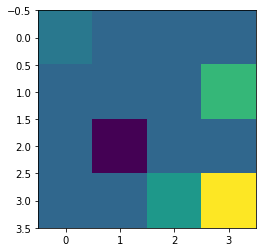

In [ ]:
env= DeterministicEnvironment()
state= env.reset()
env.render()
print('Current state : {}'.format(state))

## Stochastic Environment


*Defining a simple 4x4 stochastic environment*

In [ ]:
class StochasticEnvironment(gym.Env):
  metadata= {'render.modes': []}

  def __init__(self):
    '''
    Initializes the number of states, action, & maximum timestep of the environment
    '''

    self.observation_space= spaces.Discrete(N_STATES)
    self.action_space= spaces.Discrete(N_ACTIONS)
    self.max_timesteps= MAX_TIMESTEPS

  def reset(self):
    '''
    Resets the environment to its default setup

    Output:
      observation: 2-element list - Coordinates of the agent's default position in the grid
    '''

    self.timestep= 0

    self.agent_pos= AGENT_POS.copy()
    self.diamond_pos= DIAMOND_POS.copy()
    self.coin_pos= COIN_POS.copy()
    self.monster_pos= MONSTER_POS.copy()
    self.goal_pos= GOAL_POS.copy()

    self.state= np.zeros((4, 4))

    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10
    
    agent_state= self.agent_pos

    return STATE_LOOKUP[tuple(agent_state)]
  
  def step(self, action):
    '''
    1. Randomly chooses the action to be performed
    1. Moves the agent as per the chosen action
    2. Sets the rewards per state in the environment
    3. Calculates the reward of the new state

    Input:
      action: int - Action to be performed

    Output:
      action: int - Action taken
      observation: 2-element list
      reward: int - State reward
      done: bool - Denotes if the learning is complete (or) goal is reached
      info: dict
    '''

    # Initializing the grid
    self.state= np.zeros((4, 4))

    # Defining stochasticity to the environment
    action= action if random.uniform(0, 1) < 0.75 else random.choice([i for i in range(self.action_space.n) if i != action])

    # Move the agent
    if action == 0: # Go down one step
      self.agent_pos[0] += 1
    if action == 1: # Go up one step
      self.agent_pos[0] -= 1
    if action == 2: # Go right one step
      self.agent_pos[1] += 1
    if action == 3: # Go left one step
      self.agent_pos[1] -= 1

    # To keep the agent within the confines of the environment
    self.agent_pos= np.clip(self.agent_pos, 0, 3)

    # Initialize the state rewards
    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10

    agent_state= self.agent_pos

    # Calculates the reward for the action
    reward= 0
    if (self.agent_pos == self.diamond_pos).all():
      reward += 5
    if (self.agent_pos == self.coin_pos).all():
      reward += 3
    if (self.agent_pos == self.monster_pos).all():
      reward -= 5
    if (self.agent_pos == self.goal_pos).all():
      reward += 10

    # Timestep increment
    self.timestep += 1

    done= True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    info= {}

    return STATE_LOOKUP[tuple(agent_state)], reward, done, info

  def render(self):
    '''
    Provides pictorial representation of environment
    '''

    plt.imshow(self.state)

*Test render*

Current state : 0


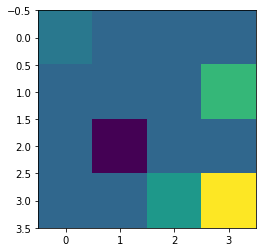

In [ ]:
env= StochasticEnvironment()
state= env.reset()
env.render()
print('Current state : {}'.format(state))

## Random Agent

*Defining a random agent*

In [ ]:
class RandomAgent:
  
  def __init__(self, env):
    '''
    Initializes a random agent and its parameters

    Input:
      env: environment class instance - Environment in which the agent will act in
    '''
    self.env= env
    self.observation_space= env.observation_space
    self.action_space= env.action_space

  def step(self, state):
    '''
    Chooses an action at random from action set

    Input:
      state: int - State of the agent
    
    Output:
      int - Randomly chosen action
    '''
    return np.random.choice(self.action_space.n)

## Defining agents that learn using Tabular methods


### Q-learning agent

*Defining a Q learning agent*

In [ ]:
# Subclass of the Random agent class
class QLearningAgent(RandomAgent):

  def __init__(self, env, discount_rate= 0.99, learning_rate= 0.01, epsilon= 1.0):
    '''
    Initializes a Q-learning agent and its parameters

    Input:
      env: environment class instance - Environment in which the agent will act in
      discount_rate: float - Rate at which the reward decays (Default 0.99)
      learning_rate: float - Rate at which the agent learns (Default 0.01)
      epsilon: float - Balances the action of the agent between exploration & exploitation (Default 1.0)
    '''
    super().__init__(env)

    # Sets the exploration, exploitation balance
    # Closer to 1.0 - exploration | Closer to 0.0 - exploitation
    self.epsilon= epsilon 

    # Sets the learning & decay parameters
    self.gamma= discount_rate
    self.alpha= learning_rate

    self.build_model()

  def build_model(self):
    '''
    Initializes the Q-table when an object is created
    '''
    self.Q_table= np.zeros((self.observation_space.n, self.action_space.n))

  def save_model(self, filename):
    '''
    Saves the model (Q-table) to the working directory
    '''
    pickle.dump(self.Q_table, open(filename, 'wb'))

  def step(self, state: int):
    '''
    Moves the agent based on epsilon value

    Input:
      state: int - State of the agent

    Output:
      int - Chosen action based on set epsilon value
    '''
    Q_state= self.Q_table[state]
    greedy_action= np.argmax(Q_state)
    random_action= super().step(state)

    # Depending on the epsilon value greedy or random action is chosen
    return random_action if random.random() < self.epsilon else greedy_action

  def train(self, experience: tuple):
    '''
    Updates the Q-table based on 'experience' of the agent

    Input:
      experience: tuple
        state: int - State of the agent
        action: int - Action performed by the agent
        next_state: int - Current state of the agent
        reward: int - Value of the state
        done: bool
    '''
    state, action, next_state, reward, done= experience
    
    # Q-value calculation
    Q_next= np.zeros([self.action_space.n]) if done else self.Q_table[next_state]
    Q_value= reward + self.gamma * np.max(Q_next) - self.Q_table[state, action]
    self.Q_table[state, action] += self.alpha * Q_value

    if done:
      # Setting exponential epsilon decay to prefer exploitation over exploration
      self.epsilon= self.epsilon * 0.99

## Running various agents in environment

*Running the random agent in the Deterministic Environment*

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

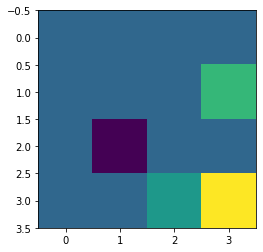

<IPython.core.display.Javascript object>

Agent has reached the Goal position
At the end of the run, the agent is at state 15 & got a total reward of 25


In [ ]:
environment= DeterministicEnvironment()
random_agent= RandomAgent(env= environment)
state= environment.reset()
done= False

grid= widgets.Grid(1, 1)

total_reward= 0
while not done:
  action= random_agent.step(state= state)
  next_state, reward, done, info= environment.step(action= action)
  # print('By taking action \'{}\' the agent moved from {} to {} and got reward {}'.format(ACTION_LOOKUP[action], state, next_state, reward))
  state= next_state
  total_reward+= reward

  with grid.output_to(0, 0):
    grid.clear_cell()
    environment.render()
    # time.sleep(1)

if done == True and environment.timestep < MAX_TIMESTEPS:
  print('Agent has reached the Goal position')
elif done == True and environment.timestep == MAX_TIMESTEPS:
  print('Agent ran out of time')

print('At the end of the run, the agent is at state {} & got a total reward of {}'.format(state, total_reward))

*Running the random agent in the Stochastic Environment*

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

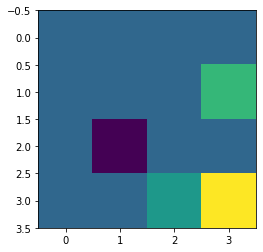

<IPython.core.display.Javascript object>

Agent has reached the Goal position
At the end of the run, the agent got is at state 15 & a total reward of -2


In [ ]:
environment= StochasticEnvironment()
random_agent= RandomAgent(env= environment)
state= environment.reset()
done= False

grid= widgets.Grid(1, 1)

total_reward= 0
while not done:
  action= random_agent.step(state= state)
  next_state, reward, done, info= environment.step(action= action)
  # print('By taking action \'{}\' the agent moved from {} to {} and got reward {}'.format(ACTION_LOOKUP[action], state, next_state, reward))
  state= next_state
  total_reward += reward

  with grid.output_to(0, 0):
    grid.clear_cell()
    environment.render()
    # time.sleep(1)

if done == True and environment.timestep < MAX_TIMESTEPS:
  print('Agent has reached the Goal position')
elif done == True and environment.timestep == MAX_TIMESTEPS:
  print('Agent ran out of time')

print('At the end of the run, the agent got is at state {} & a total reward of {}'.format(state, total_reward))

*Initializing the episode count & window size (for testing)*

In [ ]:
episodes= 1000
window_size= 100

*Running the Q-learning random agent in the Deterministic Environment*

In [ ]:
# Initializing the environment & the Q-learning agent
environment= DeterministicEnvironment()
Q_agent= QLearningAgent(env= environment)

In [ ]:
# Metrics to calculate
reached= 0
not_reached= 0
total_reward= 0

Q_det_bad_state= list()
Q_det_reward_mean= list()
Q_det_epsilon_decay= list()
Q_det_reach_windowed= list()
Q_det_episode_reward= list()
Q_det_episode_timestep= list()

for each_episode in range(episodes):
  state= environment.reset()
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  bad_state= 0

  while not done:
    action= Q_agent.step(state= state)
    next_state, reward, done, info= environment.step(action= action)
    Q_agent.train(experience= (state, action, next_state, reward, done))
    state= next_state

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1
    bad_state += 1 if (reward<0) else 0

  Q_det_bad_state.append(bad_state)
  Q_det_episode_timestep.append(timestep_per_episode)
  Q_det_epsilon_decay.append(Q_agent.epsilon)
  Q_det_episode_reward.append(reward_per_episode)
  Q_det_reward_mean.append(np.mean(np.array(Q_det_episode_reward)))

  if done == True and environment.timestep < MAX_TIMESTEPS:
    # Agent has reached the goal
    reached += 1
    Q_det_reach_windowed.append(1)
  elif done == True and environment.timestep == MAX_TIMESTEPS:
    # Agent ran out of time & has not reached the goal
    not_reached += 1
    Q_det_reach_windowed.append(0)

print('\nReached: {} & Not reached: {}'.format(reached, not_reached))
print('At the end of the run, the agent got is at state {} & a total reward of {}'.format(state, total_reward))

# print('\nThe final q-table is')
# print(Q_agent.Q_table)


Reached: 282 & Not reached: 718
At the end of the run, the agent got is at state 7 & a total reward of 182288


*Running the Q-learning random agent in the Stochastic Environment*

In [ ]:
# Initializing the environment & the Q-learning agent
environment= StochasticEnvironment()
Q_agent= QLearningAgent(env= environment)

In [ ]:
# Metrics to calculate
reached= 0
not_reached= 0
total_reward= 0

Q_sto_bad_state= list()
Q_sto_reward_mean= list()
Q_sto_epsilon_decay= list()
Q_sto_reach_windowed= list()
Q_sto_episode_reward= list()
Q_sto_episode_timestep= list()

for each_episode in range(episodes):
  state= environment.reset()
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  bad_state= 0

  while not done:
    action= Q_agent.step(state= state)
    next_state, reward, done, info= environment.step(action= action)
    Q_agent.train(experience= (state, action, next_state, reward, done))
    state= next_state

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1
    bad_state += 1 if (reward<0) else 0

  Q_sto_bad_state.append(bad_state)
  Q_sto_episode_timestep.append(timestep_per_episode)
  Q_sto_epsilon_decay.append(Q_agent.epsilon)
  Q_sto_episode_reward.append(reward_per_episode)
  Q_sto_reward_mean.append(np.mean(np.array(Q_sto_episode_reward)))

  if done == True and environment.timestep < MAX_TIMESTEPS:
    # Agent has reached the goal
    reached += 1
    Q_sto_reach_windowed.append(1)
  elif done == True and environment.timestep == MAX_TIMESTEPS:
    # Agent ran out of time & has not reached the goal
    not_reached += 1
    Q_sto_reach_windowed.append(0)

print('\nReached: {} & Not reached: {}'.format(reached, not_reached))
print('At the end of the run, the agent got is at state {} & a total reward of {}'.format(state, total_reward))

# print('\nThe final q-table is')
# print(Q_agent.Q_table)


Reached: 924 & Not reached: 76
At the end of the run, the agent got is at state 15 & a total reward of 38786


## Results, analysis, & explanation

,,
,,
,,
,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cummulative reward per episode


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Average reward per episode


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epsilon decay


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Average number of timesteps per episode


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Average number of times agent 
receives penalty per episode


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Percentage of goal achievements by 
agent for every 100 episodes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of Q-learning agent in 
Deterministic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

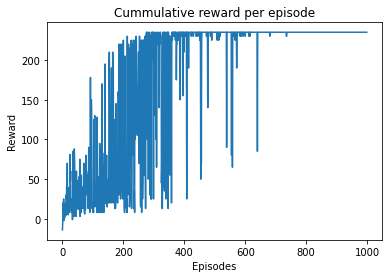

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

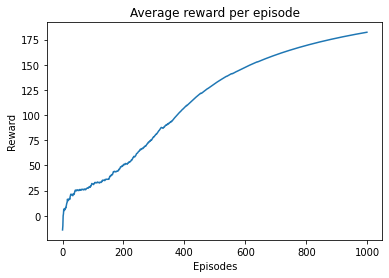

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

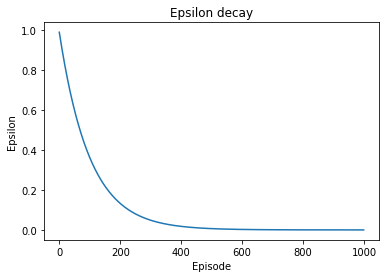

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

41.286


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.095


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[93, 89, 63, 27, 5, 4, 1, 0, 0, 0]


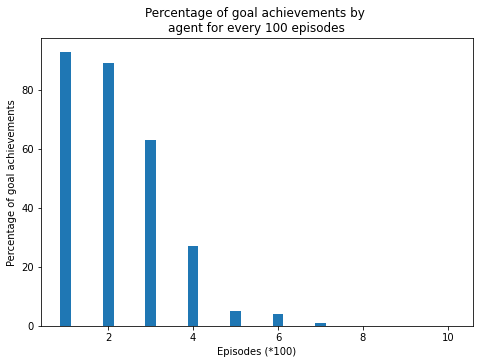

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of Q-learning agent in 
Stochastic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

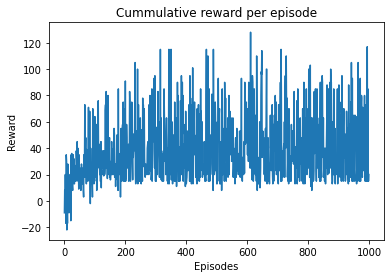

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

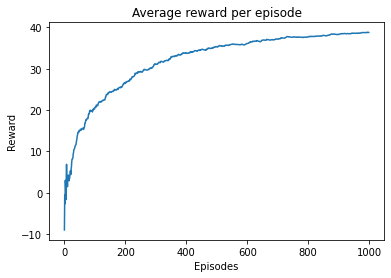

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

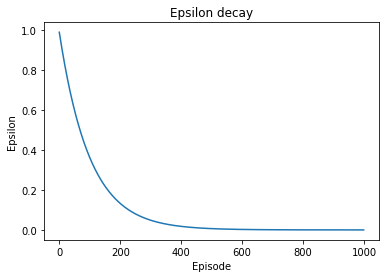

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

22.265


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.223


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[82, 95, 93, 95, 94, 97, 90, 93, 95, 90]


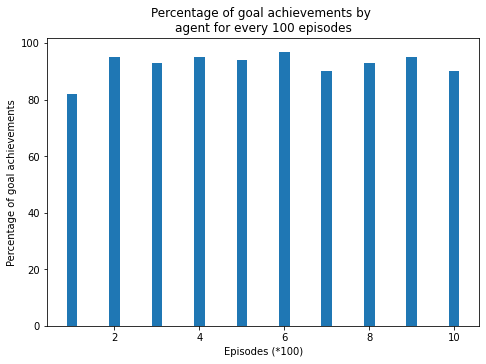

<IPython.core.display.Javascript object>

In [ ]:
grid= widgets.Grid(7, 3)

# ---------------------------------------------------------
# Column 0 -> Evaluation metrics
# ---------------------------------------------------------
with grid.output_to(1, 0):
  print('Cummulative reward per episode')
with grid.output_to(2, 0):
  print('Average reward per episode')
with grid.output_to(3, 0):
  print('Epsilon decay')
with grid.output_to(4, 0):
  print('Average number of timesteps per episode')
with grid.output_to(5, 0):
  print('Average number of times agent \nreceives penalty per episode')
with grid.output_to(6, 0):
  print('Percentage of goal achievements by \nagent for every {} episodes'.format(window_size))

# ---------------------------------------------------------
# Column 1 -> Q-learning agent in Deterministic Environment
# ---------------------------------------------------------
with grid.output_to(0, 1):
  print('Performance of Q-learning agent in \nDeterministic Environment')

with grid.output_to(1, 1):
  plt.title('Cummulative reward per episode')
  plt.plot(Q_det_episode_reward)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

with grid.output_to(2, 1):
  plt.title('Average reward per episode')
  plt.plot(Q_det_reward_mean)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

with grid.output_to(3, 1):
  plt.title('Epsilon decay')
  plt.plot(Q_det_epsilon_decay)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon')

with grid.output_to(4, 1):
  print(np.mean(np.array(Q_det_episode_timestep)))

with grid.output_to(5, 1):
  print(np.mean(np.array(Q_det_bad_state)))

with grid.output_to(6, 1):
  y_axis= [np.count_nonzero(i) for i in list(np.array(Q_det_reach_windowed).reshape(int(episodes/window_size), window_size))]
  fig= plt.figure()
  axis= fig.add_axes([0, 0, 1, 1])
  axis.bar([i for i in range(1, 11)], y_axis, width= 0.25)
  axis.set_title('Percentage of goal achievements by \nagent for every {} episodes'.format(window_size))
  axis.set_xlabel('Episodes (*100)')
  axis.set_ylabel('Percentage of goal achievements')
  fig.show()
  print(y_axis)

# ------------------------------------------------------
# Column 2 -> Q-learning agent in Stochastic Environment
# ------------------------------------------------------
with grid.output_to(0, 2):
  print('Performance of Q-learning agent in \nStochastic Environment')

with grid.output_to(1, 2):
  plt.title('Cummulative reward per episode')
  plt.plot(Q_sto_episode_reward)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

with grid.output_to(2, 2):
  plt.title('Average reward per episode')
  plt.plot(Q_sto_reward_mean)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

with grid.output_to(3, 2):
  plt.title('Epsilon decay')
  plt.plot(Q_sto_epsilon_decay)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon')

with grid.output_to(4, 2):
  print(np.mean(np.array(Q_sto_episode_timestep)))

with grid.output_to(5, 2):
  print(np.mean(np.array(Q_sto_bad_state)))

with grid.output_to(6, 2):
  y_axis= [np.count_nonzero(i) for i in list(np.array(Q_sto_reach_windowed).reshape(int(episodes/window_size), window_size))]
  fig= plt.figure()
  axis= fig.add_axes([0, 0, 1, 1])
  axis.bar([i for i in range(1, 11)], y_axis, width= 0.25)
  axis.set_title('Percentage of goal achievements by \nagent for every {} episodes'.format(window_size))
  axis.set_xlabel('Episodes (*100)')
  axis.set_ylabel('Percentage of goal achievements')
  fig.show()
  print(y_axis)

#### **Report**

1. **Cummulative reward earned per episode** \
Deterministic environment (DE): Stays high beyond 600 or so episodes as the agent learns to always uses the same path to goal. \
Stochastic environment (SE): Stays unstable because of the inherent stochasticity of the environment and also because of the epsilon value that is set to 1.0, meaning higher tendency to explore rather than exploit.
2. **Average reward per episode** \
The average reward er episode rises as expected over 1000 episodes, but in SE, the agent starts to return higher reward earlier than in DE, as the agent by chance finds a better path to get to goal.
3. **Average number of timesteps per episode** \
Agent in DE, on average, takes more timesteps to reach the goal that in SE
4. **Average number of times agent receives penalty per episode** \
Agent in SE tends to step on penalty state more than when in DE because the state exploration happens at random.
5. **Percentage of goal achievement by the agent for every 100 episodes** \
Agent in SE has a higher percentage of achieving the goal when compared to when in DE.

## References
1. Reinforcement Learning: An Introduction by Richard S. Sutton & Andrew G. Barto - http://incompleteideas.net/book/RLbook2020.pdf
2. Q-learning [Wikipedia] - https://en.wikipedia.org/wiki/Q-learning
3. An Introduction to Q-Learning [Youtube] - https://youtu.be/wN3rxIKmMgE
4. Simple Reinforcement Learning: Q-learning - https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
5. Introduction to Various Reinforcement Learning Algorithms. Part I (Q-Learning, SARSA, DQN, DDPG) - https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287